# GOES GLM 

## Justin Richling
## 11/20/18

# GOES Channels

Plot the 2 main images: 

* Clean Infrared (Band 13)

* Lightning Mapper

## Imports

In [ ]:
# Random Library Imports
import subprocess,os,glob,re,io,sys,time

# Importing Datetime Libraries
from datetime import datetime

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np

# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.plots.ctables import registry

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# Ipyhton Options
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display, Image

# Matplotlib Plotting Libraries
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap

## Populate lists for each channel

In [ ]:
# Pull the current time
now = datetime.now()
# Set the time for the data files if not current
dt = datetime(2019, 1, 19, 14)

# Pull the Julian day number for file searching
JulianDate = int(now.strftime('%j')) 
print JulianDate
print dt.strftime('%j')

GOES_sample_path = '/path/to/data files/' # Use full path to file

TIME = 1447
# Assumed that these are radiance files for the CONUS extent; customize as necessary
############################################################################################
# Channel 1
GOES_samples_1 = []
for name in glob.glob(GOES_sample_path+'OR*L1b*RadC*C01*G16*'+'{0:%Y%j}'.format(dt)+'*.nc'):
    GOES_samples_1.append(name)
GOES_samples_1 = [os.path.join(GOES_sample_path, s) for s in GOES_samples_1]
GOES_samples_1 = sorted(GOES_samples_1, key=lambda x: int(re.sub('\D', '', x)))

############################################################################################
# Channel 2
GOES17_samples_2 = []
for name in glob.glob(GOES_sample_path+'OR*L1b*RadC*C02*G16*'+'{0:%Y%j}'.format(dt)+'*.nc'):
    GOES17_samples_2.append(name)
GOES17_samples_2 = [os.path.join(GOES_sample_path, s) for s in GOES17_samples_2]
GOES17_samples_2 = sorted(GOES17_samples_2, key=lambda x: int(re.sub('\D', '', x)))

############################################################################################
# Channel 3
GOES_samples_3 = []
for name in glob.glob(GOES_sample_path+'OR*L1b*RadC*C03*G16*'+'{0:%Y%j}'.format(dt)+'*.nc'):
    GOES_samples_3.append(name)
GOES_samples_3 = [os.path.join(GOES_sample_path, s) for s in GOES_samples_3]
GOES_samples_3 = sorted(GOES_samples_3, key=lambda x: int(re.sub('\D', '', x)))

############################################################################################
# Channel 9
GOES_samples_9 = []
for name in glob.glob(GOES_sample_path+'OR*L1b*RadC*C09*G16*'+'{0:%Y%j%H}'.format(dt)+'*.nc'):
    GOES_samples_9.append(name)
GOES_samples_9 = [os.path.join(GOES_sample_path, s) for s in GOES_samples_9]
GOES_samples_9 = sorted(GOES_samples_9, key=lambda x: int(re.sub('\D', '', x)))

############################################################################################
# Channel 13
GOES_samples_13 = []
for name in glob.glob(GOES_sample_path+'OR*L1b*RadC*C13*G16*'+'{0:%Y%j%H}'.format(dt)+'*.nc'):
    GOES_samples_13.append(name)
#GOES_samples_13 = [os.path.join(GOES_sample_path, s) for s in GOES_samples_13]
GOES_samples_13 = sorted(GOES_samples_13, key=lambda x: int(re.sub('\D', '', x)))

############################################################################################
# GLM
GOES_samples_GLM = []
for name in glob.glob(GOES_sample_path+'OR*GLM*s'+'{:%Y%j}'.format(dt)+str(TIME)+'*.nc'):
    GOES_samples_GLM.append(name)
GOES_samples_GLM = [os.path.join(GOES_sample_path, s) for s in GOES_samples_GLM]
GOES_samples_GLM = sorted(GOES_samples_GLM, key=lambda x: int(re.sub('\D', '', x)))

print GOES_samples_13[4]
print list(GOES_samples_GLM)
GOES_samples_GLM[0][52:55]

# Find and convert Julian day to date 
import datetime as DT
dt = datetime(2018,1,1)
dtdelta = DT.timedelta(days=int(GOES_samples_GLM[0][52:55])-1)
day = dt + dtdelta
print '{0:%m_%d}'.format(day)
title = GOES_samples_GLM[0][48:52]+' {0:%B %d}'.format(day)+" "+\
    GOES_samples_GLM[0][55:57]+":"+GOES_samples_GLM[0][57:59]+"Z"
#print title

fileend = GOES_samples_GLM[0][48:52]+'_{0:%m_%d}'.format(day)+"_"+\
    GOES_samples_GLM[0][55:57]+"_"+GOES_samples_GLM[0][57:59]+"Z"
fileend

## Figure out where the saved images will be placed

In [ ]:
# Set a path to save the plots with string format for the date to set the month and day 
im_save_path ="/path/to/saved images/"
print im_save_path

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)


## Pull important information from the metadata

In [ ]:
IR_path = GOES_samples_13[4]
print IR_path

# pull the name of the file from the full file path
ir_name = IR_path[-76:]
print ir_name

# set the title of image form the name of the file
ir_title = ir_name[27:31]+"_"+ir_name[31:34]+"_"+ir_name[34:36]+"_"+ir_name[36:38]
print ir_title

# open the file and read the radiance data
nc_IR = Dataset(IR_path)
data_IR = nc_IR.variables['Rad'][:]

# 
fk1 = nc_IR.variables['planck_fk1'][0]
fk2 = nc_IR.variables['planck_fk2'][0]
bc1 = nc_IR.variables['planck_bc1'][0]
bc2 = nc_IR.variables['planck_bc2'][0]

data_IR = (fk2 / ( np.log((fk1 / data_IR) + 1 )) - bc1) / bc2

# satellite height
sat_h = nc_IR.variables['goes_imager_projection'].perspective_point_height

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = nc_IR.variables['x'][:] * sat_h
Y = nc_IR.variables['y'][:] * sat_h

# data for projection mapping
proj_var = nc_IR.variables['goes_imager_projection']
sat_height = proj_var.perspective_point_height
central_lon = proj_var.longitude_of_projection_origin
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis

## Test the GLM data and see what is in the file

In [49]:
glm = Dataset(GOES_samples_GLM[0], 'r')
list(glm.variables)

[u'event_id',
 u'event_time_offset',
 u'event_lat',
 u'event_lon',
 u'event_energy',
 u'event_parent_group_id',
 u'group_id',
 u'group_time_offset',
 u'group_frame_time_offset',
 u'group_lat',
 u'group_lon',
 u'group_area',
 u'group_energy',
 u'group_parent_flash_id',
 u'group_quality_flag',
 u'flash_id',
 u'flash_time_offset_of_first_event',
 u'flash_time_offset_of_last_event',
 u'flash_frame_time_offset_of_first_event',
 u'flash_frame_time_offset_of_last_event',
 u'flash_lat',
 u'flash_lon',
 u'flash_area',
 u'flash_energy',
 u'flash_quality_flag',
 u'product_time',
 u'product_time_bounds',
 u'lightning_wavelength',
 u'lightning_wavelength_bounds',
 u'group_time_threshold',
 u'flash_time_threshold',
 u'lat_field_of_view',
 u'lat_field_of_view_bounds',
 u'goes_lat_lon_projection',
 u'event_count',
 u'group_count',
 u'flash_count',
 u'percent_navigated_L1b_events',
 u'yaw_flip_flag',
 u'nominal_satellite_subpoint_lat',
 u'nominal_satellite_height',
 u'nominal_satellite_subpoint_lon',
 

## Since the GLM is activated 3 times a minute, three GLM files will be used per one GOES IR image

In [ ]:
list(GOES_samples_GLM)

## Get the flash data from the files

In [42]:
glm_1 = Dataset(GOES_samples_GLM[0], 'r')
event_lat_1 = glm_1.variables['event_lat'][:]
event_lon_1 = glm_1.variables['event_lon'][:]

group_lat_1 = glm_1.variables['group_lat'][:]
group_lon_1 = glm_1.variables['group_lon'][:]

flash_lat_1 = glm_1.variables['flash_lat'][:]
flash_lon_1 = glm_1.variables['flash_lon'][:]

glm_2 = Dataset(GOES_samples_GLM[1], 'r')
event_lat_2 = glm_2.variables['event_lat'][:]
event_lon_2 = glm_2.variables['event_lon'][:]

group_lat_2 = glm_2.variables['group_lat'][:]
group_lon_2 = glm_2.variables['group_lon'][:]

flash_lat_2 = glm_2.variables['flash_lat'][:]
flash_lon_2 = glm_2.variables['flash_lon'][:]

glm_3 = Dataset(GOES_samples_GLM[2], 'r')
event_lat_3 = glm_3.variables['event_lat'][:]
event_lon_3 = glm_3.variables['event_lon'][:]

group_lat_3 = glm_3.variables['group_lat'][:]
group_lon_3 = glm_3.variables['group_lon'][:]

flash_lat_3 = glm_3.variables['flash_lat'][:]
flash_lon_3 = glm_3.variables['flash_lon'][:]

## Set the map projections

In [43]:
globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

plotcrs = ccrs.LambertConformal(central_latitude=[30, 60],central_longitude=-100)
#plotcrs = ccrs.PlateCarree(central_longitude=central_lon)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
#extent = [-130., -70, 20., 60.]
extent = [-95., -80, 22., 37.]
#extent = [-120., -110, 22., 37.]

## Plot the IR and GLM data!

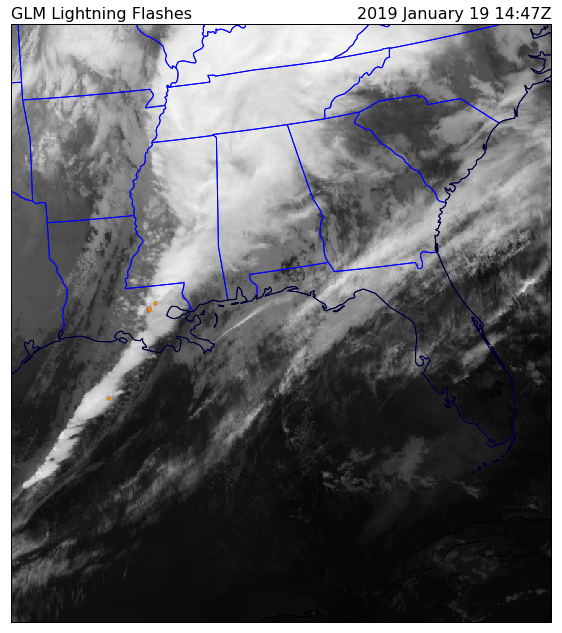

In [47]:
# Create new figure
fig = plt.figure(figsize=(17., 11.))

# Add the map and set the extent
ax = plt.subplot(111, projection=plotcrs)

#Set the lon and lat boundaries
ax.set_extent(extent, datacrs)

# Add state boundaries to plot
ax.add_feature(states_provinces, edgecolor='blue', linewidth=1)

# Add country borders to plot
ax.add_feature(country_borders, edgecolor='black', linewidth=1)

# Plot Title
plt.title('GLM Lightning Flashes', fontsize=16,loc='left')
plt.title(title, fontsize=16,loc='right')
                                           
img = ax.imshow(data_IR[:,:],origin='upper',extent=(X.min(), X.max(), Y.min(), Y.max()),
        interpolation='nearest',transform=crs,cmap='gist_gray_r') # cmap=IR_cmap,vmin=162.,vmax=330. 

#flash_x = flash_lon
#flash_y = flash_lat
 # ,edgecolors='orange'
ax.scatter(flash_lon_1, flash_lat_1, c='r', transform=datacrs,s=8)
ax.scatter(flash_lon_1, flash_lat_1, c='y', transform=datacrs,s=3.5)

ax.scatter(flash_lon_2, flash_lat_2, c='r', transform=datacrs,s=8)
ax.scatter(flash_lon_2, flash_lat_2, c='y', transform=datacrs,s=3.5)

ax.scatter(flash_lon_3, flash_lat_3, c='r', transform=datacrs,s=8)
ax.scatter(flash_lon_3, flash_lat_3, c='y', transform=datacrs,s=3.5)

plt.show()

outfile=im_save_path+"GLM_"+fileend+".png"
#fig.savefig("/Users/chowdahead/Desktop/GOES_GLM_"+str(TIME)+".png",bbox_inches='tight',dpi=120)
fig.savefig(outfile,bbox_inches='tight',dpi=120)
#print "done."